드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


라이브러리 

In [2]:
import os.path
import os
from os.path import join
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display


import torch
import torch.nn as nn


import librosa
import glob, pickle
import librosa, librosa.display 

## 음악다중감성분류

데이터 감성 칼럼 생성

In [5]:
mf=pd.read_csv('/content/drive/MyDrive/졸프/data.csv')

In [6]:
mf=mf.iloc[:,0:11]

In [7]:
what=[]

In [8]:
for i in range(400):
  a=0
  b=0
  c=0
  d=0
  e=0
  f=0
  g=0
  h=0
  m=0
  total=[]
  for x in mf[mf['track id']==i].index:
      a=a+mf[' amazement'][x]
      b=b+mf[' solemnity'][x]
      c=c+mf[' tenderness'][x]
      d=d+mf[' nostalgia'][x]
      e=e+mf[' calmness'][x]
      f=f+mf[' power'][x]
      g=g+mf[' joyful_activation'][x]
      h=h+mf[' tension'][x]
      m=m+mf[' sadness'][x]


  total.append(a)
  total.append(b)
  total.append(c)
  total.append(d)
  total.append(e)
  total.append(f)
  total.append(g)
  total.append(h)
  total.append(m)
  
  maxnum=total.index(max(total))
  if maxnum==0:
    maxal='amazement'
  elif maxnum==1:
    maxal='solemnity'
  elif maxnum==2:
    maxal='tenderness'
  elif maxnum==3:
    maxal='nostalgia'

  elif maxnum==4:
    maxal='calmness'
  elif maxnum==5:
    maxal='power'

  elif maxnum==6:
    maxal='joyful_activation'

  elif maxnum==7:
    maxal='tension'

  elif maxnum==8:
    maxal='sadness'
    
  what.append(maxal)


In [9]:
whatdf=pd.DataFrame(what, columns={'feeling'})

In [89]:
whatdf['feeling'].unique()

array(['amazement', 'calmness', 'joyful_activation', 'nostalgia', 'power',
       'tenderness', 'solemnity', 'sadness', 'tension'], dtype=object)

In [10]:

os.chdir('/content/drive/MyDrive/졸프')
whatdf.to_csv("musicfeel.csv",encoding='utf-8')

데이터 path 칼럼 만들기

In [11]:
feel=pd.read_csv('/content/drive/MyDrive/졸프/musicfeel.csv')

In [12]:
datap=[]
for i in range(400):
  if i<100:
    datap.append("/content/drive/MyDrive/졸프/emotifymusic/classical/"+str(i+1)+".mp3")
  elif i<200:
    datap.append("/content/drive/MyDrive/졸프/emotifymusic/rock/"+str((i+1)-100)+".mp3")

  elif i<300:
    datap.append("/content/drive/MyDrive/졸프/emotifymusic/electronic/"+str((i+1)-200)+".mp3")
  elif i<400:
    datap.append("/content/drive/MyDrive/졸프/emotifymusic/pop/"+str((i+1)-300)+".mp3")


musicpath=pd.DataFrame(datap, columns={"path"})

In [13]:
os.chdir('/content/drive/MyDrive/졸프')
musicpath.to_csv("musicpath.csv",encoding='utf-8')

데이터 불균형확인

In [14]:
feel.drop('Unnamed: 0', inplace=True, axis=1)

In [15]:
feel.value_counts()

feeling          
calmness             98
joyful_activation    93
nostalgia            53
tension              43
power                34
solemnity            29
tenderness           27
sadness              19
amazement             4
dtype: int64

In [16]:
feel2=feel.copy()

In [17]:
feel2.loc[feel2[feel2['feeling']=='nostalgia'].index]='sadness'
feel2.loc[feel2[feel2['feeling']=='amazement'].index]='joyful_activation'
feel2.loc[feel2[feel2['feeling']=='tension'].index]='anger'
feel2.loc[feel2[feel2['feeling']=='power'].index]='anger'
feel2.loc[feel2[feel2['feeling']=='solemnity'].index]='anger'
feel2.loc[feel2[feel2['feeling']=='tenderness'].index]='calmness'

In [18]:
feel2.value_counts()

feeling          
calmness             125
anger                106
joyful_activation     97
sadness               72
dtype: int64

In [19]:
os.chdir('/content/drive/MyDrive/졸프')
feel2.to_csv("musicfeel_4.csv",encoding='utf-8')

데이터 합치기

In [20]:
pd_data=pd.read_csv('/content/drive/MyDrive/졸프/musicpath.csv')
pd_feel=pd.read_csv('/content/drive/MyDrive/졸프/musicfeel_4.csv')

In [21]:
data_info=pd_feel.merge(pd_data, on='Unnamed: 0')

In [22]:
data_info.drop('Unnamed: 0', inplace=True, axis=1)

In [23]:
os.chdir('/content/drive/MyDrive/졸프')
data_info.to_csv("music_data_info4.csv",encoding='utf-8')

In [24]:
music_data_info4=pd.read_csv("/content/drive/MyDrive/졸프/music_data_info4.csv")

In [25]:
music_data_info4.drop('Unnamed: 0', inplace=True, axis=1)

In [26]:
music_data_info4.head()

,feeling,path
0,joyful_activation,/content/drive/MyDrive/졸프/emotifymusic/clas...
1,calmness,/content/drive/MyDrive/졸프/emotifymusic/clas...
2,calmness,/content/drive/MyDrive/졸프/emotifymusic/clas...
3,joyful_activation,/content/drive/MyDrive/졸프/emotifymusic/clas...
4,calmness,/content/drive/MyDrive/졸프/emotifymusic/clas...


train, valid 추출하기

In [27]:
data_info2=music_data_info4.copy()

In [28]:
data_info2['genre']=''
for i in range(len(data_info2)):
  if i<100:
    data_info2['genre'][i]='classical'
  elif i<200:
    data_info2['genre'][i]='rock'

  elif i<300:
    data_info2['genre'][i]='electronic'
  else:
    data_info2['genre'][i]='pop'

In [29]:
classical=data_info2[data_info2['genre']=='classical']
rock=data_info2[data_info2['genre']=='rock']
electronic=data_info2[data_info2['genre']=='electronic']
pop=data_info2[data_info2['genre']=='pop']

In [30]:
xc,yc=train_test_split(classical,test_size=0.2, random_state=0 )
xr,yr=train_test_split(rock,test_size=0.2, random_state=0 )
xe,ye=train_test_split(electronic,test_size=0.2, random_state=0 )
xp,yp=train_test_split(pop,test_size=0.2, random_state=0 )


In [31]:
pd_train=pd.concat([xc,xr,xe,xp])
pd_test=pd.concat([yc,yr,ye,yp])

데이터 augmentation

In [32]:
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 


In [33]:
# 음악 데이터 불러오기
def load_audiofiles(file_name, sample_rate=48000):
    
    result=np.array([])
    
    audio_signal, sample_rate = librosa.load(file_name, duration=3, offset=0.5, sr=sample_rate)

    signal = np.zeros(int(sample_rate*3,))
    signal[:len(audio_signal)] = audio_signal
    
    return signal
    

In [34]:
file_index = music_data_info4[music_data_info4['feeling']=='sadness'].index
file_list=[]
for i in file_index:
  file_list.append(music_data_info4['path'][i])
sad_data=[]
for file_name in tqdm(file_list):
  sad_data.append(load_audiofiles(file_name))
  

  0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 1/72 [00:04<05:43,  4.83s/it]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 2/72 [00:05<02:54,  2.49s/it]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 3/72 [00:06<01:57,  1.71s/it]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 4/72 [00:07<01:32,  1.36s/it]/usr/local/lib/pyt

In [ ]:
#import random
#number=[]
#for j in range(10):
  #number.append(random.randrange(72))
#print(number)

In [35]:
number=[23, 0, 48, 18, 30, 67, 25, 17, 40, 29]

In [36]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])


augmented_samples=[]
for i in number:
  augmented_samples.append(augment(samples=sad_data[i], sample_rate=48000))


/usr/local/lib/python3.8/dist-packages/audiomentations/core/transforms_interface.py:57: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/audiomentations/core/transforms_interface.py:57: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


In [37]:
len(augmented_samples),augmented_samples

(10, [array([0.02041564, 0.03556306, 0.028886  , ..., 0.01484816, 0.02409143,
         0.00386399], dtype=float32),
  array([0.25946674, 0.27448002, 0.2747126 , ..., 0.20972545, 0.22726001,
         0.24992801], dtype=float32),
  array([ 0.00217961,  0.0032405 ,  0.00346787, ..., -0.00074014,
         -0.00064231,  0.00040092], dtype=float32),
  array([-0.02682202, -0.03534389, -0.03702396, ..., -0.00010844,
          0.00196268,  0.00143998], dtype=float32),
  array([-0.07026912, -0.06096352, -0.04813207, ..., -0.06059635,
         -0.07632034, -0.07510203], dtype=float32),
  array([0.1288177 , 0.14110726, 0.1254253 , ..., 0.        , 0.        ,
         0.        ], dtype=float32),
  array([-0.04433513, -0.03983986, -0.02503317, ..., -0.00583454,
         -0.00940956, -0.00887425], dtype=float32),
  array([-0.0061154 , -0.00240171,  0.00755405, ..., -0.10822998,
         -0.10223854,  0.        ], dtype=float32),
  array([-0.31646538, -0.31733608, -0.23773883, ..., -0.00728315,
    

음성데이터 불러오기

In [38]:
def load_data(data_info,tag):    

      data = []#음성 feature들을 담는다
      label = []#label을 담는다
        
      file_list = data_info['path']
      emotion_list = data_info['feeling']
      for file_name, emotion in tqdm(zip(file_list, emotion_list)):
   
          data.append(load_audiofiles(file_name))
          label.append(emotion)
      if tag==1:
        
        for i in range(len(augmented_samples)):
          data.append(augmented_samples[i])
          label.append('sadness')


      return np.array(data), np.array(label)

In [39]:
#Train, Validation 
train_data, train_label = load_data(pd_train, tag=1)
val_data, val_label = load_data(pd_test,tag=0)

0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
1it [00:00,  1.79it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
2it [00:01,  1.78it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3it [00:01,  1.60it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
4it [00:02,  1.70it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warning

In [40]:
train_data.shape, val_data.shape

((330, 144000), (80, 144000))

라벨인코딩

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_label)
y_train = le.transform(train_label)

le2 = LabelEncoder()
le2.fit(val_label)
y_val=le2.transform(val_label)

melspectrogram 전처리

In [42]:
def Calculate_Melspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

#train
mel_train = []
print("Calculate mel spectrograms for train set")
train_data = np.stack(np.array(train_data),0)

for i in range(train_data.shape[0]):
    mel_spectrogram = Calculate_Melspectrogram(train_data[i,:], sample_rate=48000)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i+1,train_data.shape[0]),end='')    
print('')
mel_train = np.stack(mel_train,axis=0)

#validation
mel_val = []
print("Calculate mel spectrograms for validation set")
val_data = np.stack(np.array(val_data),0)

for i in range(val_data.shape[0]):
    mel_spectrogram = Calculate_Melspectrogram(val_data[i,:], sample_rate=48000)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i+1,val_data.shape[0]),end='')    
print('')
mel_val = np.stack(mel_val,axis=0)


print(f'mel_train:{mel_train.shape}, mel_val:{mel_val.shape}') 

Calculate mel spectrograms for train set
 Processed 330/330 files
Calculate mel spectrograms for validation set
 Processed 80/80 files
mel_train:(330, 128, 563), mel_val:(80, 128, 563)


standard scaling

In [43]:
from sklearn.preprocessing import StandardScaler

x_train = np.expand_dims(mel_train, 1) #DataNum, 1ch, H, W
x_val = np.expand_dims(mel_val, 1)

scaler = StandardScaler()

b,c,h,w = x_train.shape
x_train = np.reshape(x_train, newshape=(b,-1))
x_train = scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(b,c,h,w))

b,c,h,w = x_val.shape
x_val = np.reshape(x_val, newshape=(b,-1))
x_val = scaler.transform(x_val)
x_val = np.reshape(x_val, newshape=(b,c,h,w))

In [44]:
x_train.shape,x_val.shape

((330, 1, 128, 563), (80, 1, 128, 563))

cnn 모델 

In [79]:
### 모델1- 매번 dropout하기, 합성곱층 4개 

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()

        # 1. conv block
        self.relu = nn.ReLU()
        self.conv1= nn.Conv2d(in_channels=1,
                   out_channels=16,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn1 = nn.BatchNorm2d(16)

        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do = nn.Dropout2d(p=0.3)
        # 2. conv block
        self.conv2= nn.Conv2d(in_channels=16,
                   out_channels=32,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn2 = nn.BatchNorm2d(32)
        self.mp2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.do = nn.Dropout2d(p=0.3)
        # 3. conv block
        self.conv3 = nn.Conv2d(in_channels=32,
                   out_channels=64,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn3 = nn.BatchNorm2d(64)
        self.do = nn.Dropout2d(p=0.3)

        # 4. conv block
        self.conv4= nn.Conv2d(in_channels=64,
                   out_channels=128,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn4= nn.BatchNorm2d(128)
        self.do = nn.Dropout2d(p=0.3)

        # Linear softmax layer
        self.out_linear = nn.Linear(512,num_emotions)
        self.out_softmax = nn.Softmax(dim=1)
        
    def forward(self,x):

        # transformer embedding
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.do(self.mp1(out))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.do(self.mp2(out))
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.do(self.mp2(out))
        out = self.relu(self.bn4(self.conv4(out)))
        out = self.do(self.mp2(out))


        conv_embedding = torch.flatten(out, start_dim=1)

        output_logits = self.out_linear(conv_embedding)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax  
    
model = ParallelModel(num_emotions=4).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

cpu
Number of trainable params:  99684


하이퍼 파리미터 설정

In [80]:
EPOCHS=10
DATASET_SIZE = x_train.shape[0]
BATCH_SIZE = 10


OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [81]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

loss 그래프 그리기

시각화툴 설치

In [49]:
!pip install livelossplot==0.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.9 MB/s 
  Created wheel for livelossplot: filename=livelossplot-0.1.2-py3-none-any.whl size=3829 sha256=6266bc29e251322ce18bea49f461912e6aecd2069d1525ff6ba67d724a9b03e9
  Stored in directory: /root/.cache/pip/wheels/cb/20/fc/f488a78c70bd6ca8f00123a39fe239fa80ac36523908c5d298
Successfully built livelossplot


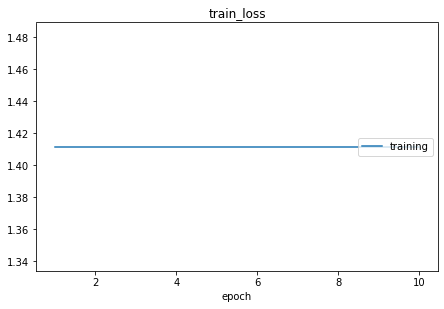

In [82]:
from livelossplot import PlotLosses
liveloss = PlotLosses()

logs = {}

model.train()

for epoch in range(EPOCHS):
    # shuffle data
    ind = np.random.permutation(DATASET_SIZE)

    x_train = x_train[ind,:,:,:]
    y_train = y_train[ind]
    
    epoch_loss = 0
    
    iters = int(DATASET_SIZE / BATCH_SIZE)
     
    for i in range(iters):
        ### indexing과정을 통해 작성된 Dataloader 코드
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        
        x = x_train[batch_start:batch_end,:,:,:]
        y = y_train[batch_start:batch_end]
       
        x_tensor = torch.tensor(x,device=device).float()
        y_tensor = torch.tensor(y,dtype=torch.long, device=device) 
        
        # forward pass
        output_logits, output_softmax = model(x_tensor)

        # compute loss
        loss = loss_fnc(output_logits, y_tensor)
        
        # compute gradients
        OPTIMIZER.zero_grad()
        loss.backward()
        # update parameters
        OPTIMIZER.step()

        epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE

    ###liveloss 함수를 사용하기 위한 코드들
    logs['train_loss'] = epoch_loss
        
    liveloss.update(logs)
    liveloss.draw()

모델 예측

In [83]:
model.eval()

predicts = []

with torch.no_grad():
    for data in tqdm(x_val):
        data = torch.FloatTensor(data).to(device).unsqueeze(1)

        _ , output_softmax = model(data)
        predictions = torch.argmax(output_softmax,dim=1).cpu().numpy()
        predicts.append(predictions)
    
print(f'predict_len:{len(predicts)}')

100%|██████████| 80/80 [00:01<00:00, 42.81it/s]

predict_len:80


In [84]:
###label encoder를 이용해 다시 문자열로 역변환
predicts = le2.inverse_transform(predicts)
predicts

array(['anger', 'calmness', 'anger', 'joyful_activation', 'anger',
       'joyful_activation', 'anger', 'joyful_activation', 'anger',
       'calmness', 'anger', 'calmness', 'calmness', 'anger', 'calmness',
       'anger', 'anger', 'anger', 'calmness', 'anger', 'anger', 'anger',
       'anger', 'anger', 'joyful_activation', 'anger', 'anger', 'anger',
       'calmness', 'anger', 'anger', 'anger', 'joyful_activation',
       'anger', 'anger', 'anger', 'anger', 'anger', 'anger',
       'joyful_activation', 'calmness', 'calmness', 'anger', 'calmness',
       'calmness', 'anger', 'joyful_activation', 'calmness', 'calmness',
       'joyful_activation', 'calmness', 'calmness', 'calmness',
       'joyful_activation', 'calmness', 'anger', 'calmness', 'calmness',
       'joyful_activation', 'calmness', 'joyful_activation', 'anger',
       'calmness', 'calmness', 'anger', 'anger', 'joyful_activation',
       'anger', 'anger', 'anger', 'joyful_activation',
       'joyful_activation', 'anger', 'ang

예측 결과 저장

In [85]:
ID = np.array([i for i in range(len(predicts))]).reshape(-1,1)

results = np.hstack([ID, np.array(predicts).reshape(-1,1)])

results =pd.DataFrame(results, columns=['ID','emotion'])
os.chdir('/content/drive/MyDrive/졸프')
results.to_csv("baseline_drop4_feel4.csv", index=False)

## fade 기술

In [54]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")

  0%|          | 0.00/427k [00:00<?, ?B/s]

fade out 함수 정의

In [55]:
import librosa  
import numpy
import soundfile
import torchaudio
import warnings
warnings.filterwarnings('ignore')

def apply_fadeout(audio, sr, duration=3.0):
    audio0=np.array(audio[0])
    audio1=np.array(audio[1])

    # 연산할 길이 계산
    length = int(duration*sr)
    end1 = len(audio1)
    start1 = end1 - length
    end0 = len(audio0)
    start0 = end0 - length

    
    # linear fade out
    fade_curve = numpy.linspace(1.0, 0.0, length)


    # apply the curve
    audio0[start0:end0] = audio0[start0:end0] * fade_curve
    audio1[start1:end1] = audio1[start1:end1] * fade_curve
    
    audio0.reshape(-1,1)
    audio1.reshape(-1,1)

    # stack
    audio01=np.vstack((audio0,audio1))
    
    return  torch.Tensor(audio01)


wave, sr = torchaudio.load(SAMPLE_WAV)

out=wave

out=apply_fadeout(out, sr, duration=2.0)



In [56]:
waveform1, sample_rate1 = torchaudio.load(SAMPLE_WAV)
print(waveform1.shape, sample_rate1)

torch.Size([2, 109368]) 44100


그래프 함수 정의

In [57]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [58]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

fade out 그래프 그리기

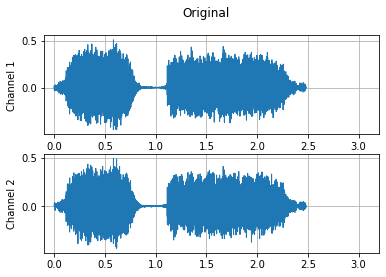

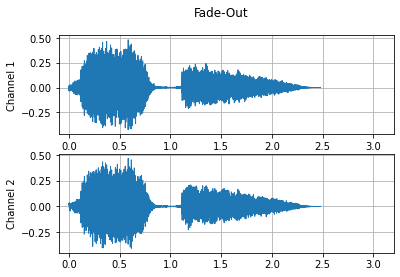

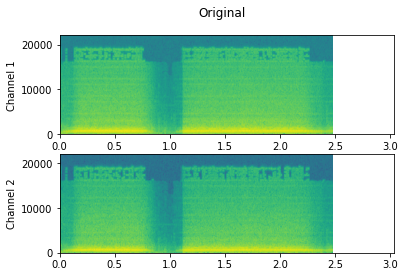

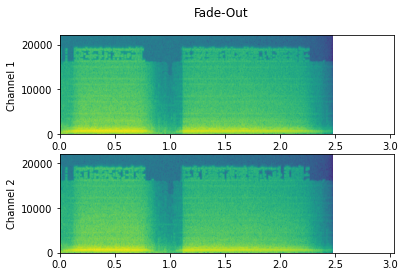

In [59]:
### 그래프 그리기

plot_waveform(wave, sr, title="Original", xlim=(-0.1, 3.2))
plot_waveform(out, sr, title="Fade-Out", xlim=(-0.1, 3.2))

plot_specgram(wave, sr, title="Original", xlim=(0, 3.04))
plot_specgram(out, sr, title="Fade-Out", xlim=(0, 3.04))



fade in 함수 정의

In [65]:
SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")

In [74]:
import librosa  
import numpy
import soundfile

import warnings
warnings.filterwarnings('ignore')
audio0=0
audio1=0
def apply_fadein(audio, sr, duration=3.0):
    audio0=np.array(audio[0])
    audio1=np.array(audio[1])

    # 연산할 길이 계산
    length = int(duration*sr)

    # linear fade in
    fade_curve = numpy.linspace(0.0,1.0, length)


    # apply the curve
    audio0[0:length] = audio0[0:length] * fade_curve
    audio1[0:length] = audio1[0:length] * fade_curve
    
    audio0.reshape(-1,1)
    audio1.reshape(-1,1)

    # stack
    audio01=np.vstack((audio0,audio1))
    
    return  torch.Tensor(audio01)


wave2, sr2 = torchaudio.load(SAMPLE_WAV)

inn=wave2

inn=apply_fadein(inn, sr2, duration=2.0)



fade in 그래프 그리기

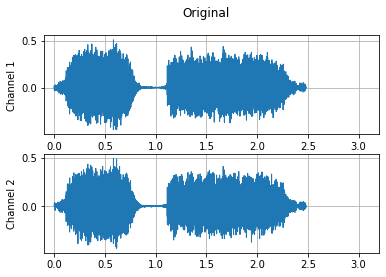

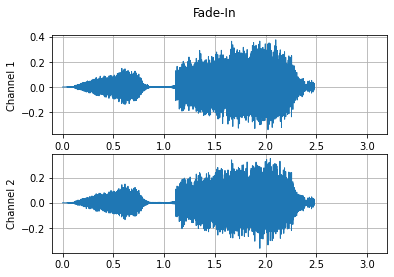

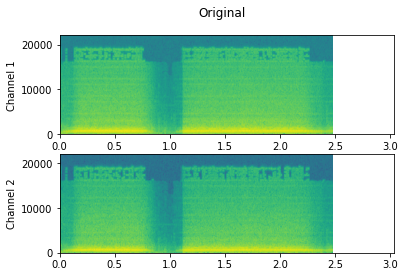

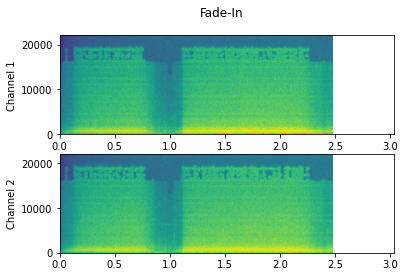

In [75]:
### 그래프 그리기

plot_waveform(wave, sr, title="Original", xlim=(-0.1, 3.2))
plot_waveform(inn, sr, title="Fade-In", xlim=(-0.1, 3.2))

plot_specgram(wave, sr, title="Original", xlim=(0, 3.04))
plot_specgram(inn, sr, title="Fade-In", xlim=(0, 3.04))


오디오 출력

In [76]:
Audio(wave, rate=sr)

In [77]:
Audio(out, rate=sr)

In [78]:
Audio(inn, rate=sr)